In [1]:
import cv2
import numpy as np
import os
import mediapipe as mp
import matplotlib.pyplot as plt
import time

In [2]:
mp_holistic=mp.solutions.holistic
mp_drawing=mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image,model):
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable=False
    results=model.process(image)
    image.flags.writeable=True
    image=cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return image,results

In [4]:
def draw_landmarks(image,results):
    mp_drawing.draw_landmarks(image,results.face_landmarks,mp_holistic.FACEMESH_TESSELATION,mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1))
 
    mp_drawing.draw_landmarks(image,results.pose_landmarks,mp_holistic.POSE_CONNECTIONS,mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image,results.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS, mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2))
    mp_drawing.draw_landmarks(image,results.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS,mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))

In [5]:
mp_drawing.draw_landmarks


<function mediapipe.python.solutions.drawing_utils.draw_landmarks(image: numpy.ndarray, landmark_list: mediapipe.framework.formats.landmark_pb2.NormalizedLandmarkList, connections: Optional[List[Tuple[int, int]]] = None, landmark_drawing_spec: Union[mediapipe.python.solutions.drawing_utils.DrawingSpec, Mapping[int, mediapipe.python.solutions.drawing_utils.DrawingSpec]] = DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=2), connection_drawing_spec: Union[mediapipe.python.solutions.drawing_utils.DrawingSpec, Mapping[Tuple[int, int], mediapipe.python.solutions.drawing_utils.DrawingSpec]] = DrawingSpec(color=(224, 224, 224), thickness=2, circle_radius=2))>

In [6]:
# Extract keypoints
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [7]:
path=os.path.join("sign_detection_data")
actions=["hello","thankyou","iloveyou"]
no_of_videos=30
no_of_frames=30



In [8]:
for action in actions:
    for i in range(no_of_videos):
        try:
            os.makedirs(os.path.join(path,action,str(i)))
        except:
            pass

In [9]:
capture=cv2.VideoCapture(0)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
  for action in actions:
    for video in range(no_of_videos):
      for frame_no in range(no_of_frames):

        #while capture.isOpened():

          ret,frame=capture.read()
          image,results=mediapipe_detection(frame,holistic)
          draw_landmarks(image,results)
          if frame_no== 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, video), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
          else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, video), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
          keypoints = extract_keypoints(results)
          npy_path = os.path.join(path, action, str(video), str(frame_no))
          np.save(npy_path, keypoints)
          cv2.imshow("OpenCV feed",image)
          if cv2.waitKey(10) & 0xFF==ord("q"):
             break
capture.release()
cv2.destroyAllWindows()

In [9]:
label={action:count for count,action in enumerate(actions)}
print(label)

{'hello': 0, 'thankyou': 1, 'iloveyou': 2}


In [10]:
data=[]
label_set=[]
for action in actions:
    for video in range(no_of_videos):
        one_data=[]
        for frame_no in range(no_of_frames):
            one_data.append(np.load(os.path.join(path,action,str(video),"{}.npy".format(frame_no))))
        data.append(one_data)
        label_set.append(label[action])

In [11]:
data=np.array(data)
label_set=np.array(label_set)

In [12]:
print(data.shape)
print(label_set.shape)

(90, 30, 1662)
(90,)


In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [14]:
label_coded=to_categorical(label_set).astype(int)

In [15]:
X_train,X_test,Y_train,Y_test=train_test_split(data,label_coded,test_size=0.05)

In [16]:
print(Y_test.shape)

(5, 3)


In [17]:
print(X_train.shape)

(85, 30, 1662)


In [20]:
pip install tensorflow


[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import TensorBoard


In [37]:
import tensorflow as tf

In [46]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [77]:
first_model=Sequential()
first_model.add(LSTM(64,return_sequences=True,activation="relu",input_shape=(30,1662)))
first_model.add(LSTM(128,return_sequences=True,activation="relu"))
first_model.add(LSTM(64,activation="relu"))
first_model.add(Dense(64,activation="relu"))
first_model.add(Dense(32,activation="relu"))
first_model.add(Dense(3,activation="softmax"))
first_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 64)            442112    
                                                                 
 lstm_13 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_14 (LSTM)              (None, 64)                49408     
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 3)                 99        
                                                                 
Total params: 596,675
Trainable params: 596,675
Non-tr

In [78]:
first_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [79]:
first_model.fit(X_train,Y_train,epochs=2000,callbacks=[tb_callback])

Epoch 1/2000
3/3 [==============================] - 13s 655ms/step - loss: 1.4301 - categorical_accuracy: 0.3294
Epoch 2/2000
3/3 [==============================] - 2s 894ms/step - loss: 1.6563 - categorical_accuracy: 0.3529
Epoch 3/2000
3/3 [==============================] - 1s 310ms/step - loss: 2.7880 - categorical_accuracy: 0.3647
Epoch 4/2000
3/3 [==============================] - 1s 229ms/step - loss: 6.9141 - categorical_accuracy: 0.2941
Epoch 5/2000
3/3 [==============================] - 1s 446ms/step - loss: 3.0332 - categorical_accuracy: 0.3647
Epoch 6/2000
3/3 [==============================] - 1s 339ms/step - loss: 38.6788 - categorical_accuracy: 0.3412
Epoch 7/2000
3/3 [==============================] - 2s 958ms/step - loss: 28.7967 - categorical_accuracy: 0.3882
Epoch 8/2000
3/3 [==============================] - 2s 1s/step - loss: 7.5091 - categorical_accuracy: 0.4706
Epoch 9/2000
3/3 [==============================] - 2s 870ms/step - loss: 12.1763 - categorical_accuracy

In [81]:
pred=first_model.predict(X_test)

1/1 [==============================] - 0s 205ms/step


In [86]:
actions[np.argmax(pred[1])]


'hello'

In [88]:
actions[np.argmax(Y_test[1])]

'hello'

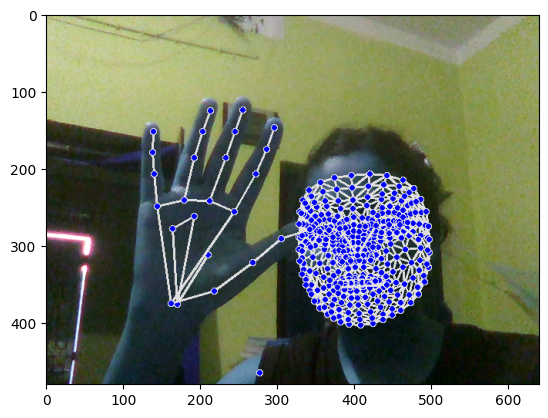

In [38]:
#frame=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
draw_landmarks(frame,results)

plt.imshow(frame)